In [1]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib as mpl
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
from torch.distributions import MultivariateNormal
import numpy as np

from pyod.models.lof import LOF

from nf_loe.nf.flows import (
    AffineConstantFlow, ActNorm, AffineHalfFlow, 
    SlowMAF, MAF, IAF, Invertible1x1Conv,
    NormalizingFlow, NormalizingFlowModel,
)
from nf_loe.nf.spline_flows import NSF_AR, NSF_CL
from nf_loe.data import SyntheticDataset, GenericDataset
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay
from nf_loe.nf.trainer import Trainer
from torch.utils.data import DataLoader
import pandas as pd

In [2]:
# setup
n_flows = 10
max_epochs = 200
batch_size = 1024 * 4
num_rows = 1024 * 10
contamination = .1

In [3]:
# train
train_set = GenericDataset("../data/PSM/train.csv", index_col="timestamp_(min)")
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)

# test
test_set = GenericDataset("../data/PSM/test.csv", index_col="timestamp_(min)")
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [4]:
num_variables = train_set[1]['sample'].shape[0]
# Vanilla model
vanilla_prior = MultivariateNormal(torch.zeros(num_variables), torch.eye(num_variables), validate_args=False)
# flow = RealNVP
vanilla_flows = [AffineHalfFlow(dim=num_variables, parity=i%2) for i in range(n_flows)]

# MAF (with MADE net, so we get very fast density estimation)
# vanilla_flows = [MAF(dim=2, parity=i%2) for i in range(n_flows)]

# construct the model
vanilla_model = NormalizingFlowModel(vanilla_prior, vanilla_flows)
# optimizer
vanilla_optimizer = optim.Adam(vanilla_model.parameters(), lr=1e-4, weight_decay=1e-5) # todo tune WD
print("number of params: ", sum(p.numel() for p in vanilla_model.parameters()))

# LOE model
loe_prior = MultivariateNormal(torch.zeros(num_variables), torch.eye(num_variables), validate_args=False)
# flow = RealNVP
loe_flows = [AffineHalfFlow(dim=num_variables, parity=i%2) for i in range(n_flows)]

# MAF (with MADE net, so we get very fast density estimation)
# loe_flows = [MAF(dim=2, parity=i%2) for i in range(n_flows)]

# construct the model
loe_model = NormalizingFlowModel(loe_prior, loe_flows)
# optimizer
loe_optimizer = optim.Adam(loe_model.parameters(), lr=1e-4, weight_decay=1e-5) # todo tune WD
print("number of params: ", sum(p.numel() for p in loe_model.parameters()))

number of params:  36730
number of params:  36730


In [5]:
def loe_loss(z):
    zs, prior_logprob, log_det = z
    log_prob = prior_logprob + log_det
    loss_n = -log_prob
    loss_a = -torch.exp(1 - torch.exp(log_prob))
    return loss_n, loss_a

def vanilla_loss(z):
    zs, prior_logprob, log_det = z
    prob = prior_logprob + log_det
    loss_n = -prob
    loss_a = 0
    return loss_n, loss_a

config = {
    'train_method': 'blind', # blind, loe_hard, loe_soft, refine, gt
    'training_epochs': max_epochs,
    'device': 'cpu'
}
loe_optimizer = optim.Adam(loe_model.parameters(), lr=1e-4, weight_decay=1e-5)
train = Trainer(loe_model, vanilla_loss, config)

Epoch: 1, TR loss: 26.171609513817074
Epoch: 2, TR loss: 23.570191197228283
Epoch: 4, TR loss: 17.609294917761794
Epoch: 6, TR loss: 8.25962968274696
Epoch: 8, TR loss: -5.488351159788951
Epoch: 10, TR loss: -13.848045191385934
Epoch: 12, TR loss: -20.008661619402027
Epoch: 14, TR loss: -23.991049659951237
Epoch: 16, TR loss: -27.062603316702017
Epoch: 18, TR loss: -29.429801254519514
Epoch: 20, TR loss: -31.22004853526166
Epoch: 22, TR loss: -32.750692552139554
Epoch: 24, TR loss: -34.11951147711747
Epoch: 26, TR loss: -35.402801156392236
Epoch: 28, TR loss: -36.61683939583789
Epoch: 30, TR loss: -37.69069526951034
Epoch: 32, TR loss: -38.588741027015196
Epoch: 34, TR loss: -39.40619032163103
Epoch: 36, TR loss: -40.252081430544756
Epoch: 38, TR loss: -41.06837961669975
Epoch: 40, TR loss: -41.813516655218486
Epoch: 42, TR loss: -42.51024297823839
Epoch: 44, TR loss: -43.16326492100754
Epoch: 46, TR loss: -43.77158988836135
Epoch: 48, TR loss: -44.34176976321133
Epoch: 50, TR loss: -4

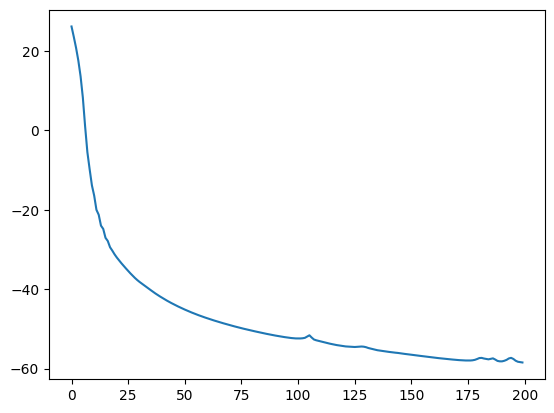

In [6]:
loss_list = train.train(
    train_loader=train_loader,
    contamination=contamination,
    optimizer=loe_optimizer,
    log_every=2
)
plt.plot(loss_list)
plt.show()

In [7]:
X = test_set[:]['sample']
y = pd.read_csv('../data/PSM/test_label.csv')['label'].values

In [8]:

# baseline
lof = LOF(n_jobs=3)
lof.fit(train_set[:]['sample'].numpy())
y_hat_lof = lof.decision_function(X)

In [9]:
y_hat_lof = lof.decision_function(X)

In [16]:
prior_logprob + log_det

tensor([ 63.2158,  62.5684,  64.5621,  ...,  24.9860, -51.8429,  27.5225],
       grad_fn=<AddBackward0>)

-1109491400000000.0

array([ 63.215828,  62.568443,  64.5621  , ...,  24.98605 , -51.842865,
        27.52253 ], dtype=float32)

3.378044e+38

array([2.8114228e-24, 4.0688546e-24, 1.3553933e-24, ..., 6.3152944e-10,
       1.1798214e+22, 9.5163159e-19], dtype=float32)

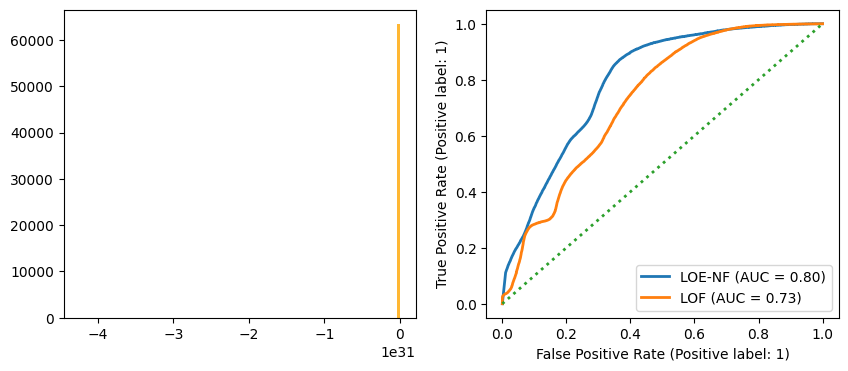

In [11]:
loe_model.eval()

plt.figure(figsize=(10,4))

# x, y = data.sample(10000)
zs, prior_logprob, log_det = loe_model(X)

probs = (prior_logprob + log_det).detach().numpy()
probs = np.exp(np.nan_to_num(probs, max(probs)))
max_ = np.nanmax(probs[probs != np.inf])
probs[np.isinf(probs)] = max_
probs = -probs

plt.subplot(121)
plt.hist(probs[y == 0], bins=100, color='orange', alpha=.8)
plt.hist(probs[y == 1], bins=100, color='blue', alpha=.8)


ax = plt.subplot(122)
# LOE NF
y_hat = probs
RocCurveDisplay.from_predictions(
    y,
    y_hat,
    pos_label=1,
    name='LOE-NF',
    linewidth=2,
    ax = ax
)
# Vanilla NF
# vanilla_model.eval()
# zs, prior_logprob, log_det = vanilla_model(x)
# RocCurveDisplay.from_predictions(
#     y,
#     -(prior_logprob + log_det).detach().numpy(),
#     pos_label=0,
#     name='Vanilla-NF',
#     linewidth=2,
#     ax = ax
# )


# # baseline
RocCurveDisplay.from_predictions(
    y,
    y_hat_lof,
    pos_label=1,
    name='LOF',
    linewidth=2,
    ax = ax
)
# random
plt.plot([0, 1], [0, 1], linewidth=2, linestyle=":")
plt.show()